In [26]:
##### REQUIRES THE DATAFRAME FOLDER TO BE NAMED 'Cohorts', WHICH INCLUDES ALL PRECOMPUTED DATAFRAMES #####
import fiber
from fiber.cohort import Cohort
from fiber.condition import Patient, MRNs
from fiber.condition import Diagnosis
from fiber.condition import Measurement, Encounter, Drug, TobaccoUse,AlcoholUse
from fiber.storage import yaml as fiberyaml
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce 

In [2]:
#load Cohorts
Case_filtered_15_540 = pq.read_table('Cohorts/Case/Case_filtered_15_540.parquet').to_pandas()
Control_filtered_15_540 = pq.read_table('Cohorts/Control/Control_filtered_15_540.parquet').to_pandas()

In [3]:
#generic function get cohort 
def df_to_cohort(df):
    mrns = list(df.index.values)
    condition = MRNs(mrns)
    return Cohort(condition)

In [4]:
#condition= FIBER Condition 
#df_mrn = pandas Data frame with Patient MRNS 
#name_df = Name o the new Dataframe
#name_feature =Feature name 
#frequency = type of occurence: EVER, COUNT,WINDOW
#Cohort_type = Case/Control
def get_has_certain_condition(condition, df_mrn, name_feature, gap_in_days, frequency, cohort_type):
    #get cohort
    Onset_column = "HT_Onset" if cohort_type == "Case" else "last_encounter"
    cohort = df_to_cohort(df_mrn)
    #get cohort with condition
    cohort_condition = cohort.get(condition)
    # Prefilter condition frame, so there are only the rows of interest --> rows which fulfill the gap condition
    try:
        Filtered_DF = df_mrn.merge(cohort_condition, left_index=True, right_on = "medical_record_number")
    except:
        print("DataFrame is empty. Condition does not fit to any record!")
        raise SystemExit(0)
    Filtered_DF = Filtered_DF.set_index("medical_record_number")
    # Use only necessary columns age_in_days + HT_Onset
    Filtered_DF = Filtered_DF[["age_in_days", Onset_column]]
    Filtered_DF = Filtered_DF.loc[(Filtered_DF[Onset_column] - Filtered_DF["age_in_days"]) >= gap_in_days]
    # Filtered_DF contains all gap relevant entries
    
    # get MRNs of input file 
    #cohort_indexes = df_mrn.index
    #get 0 for no diagnosis and 1 for has diagnosis
    cohort_mrn_diagnosis=[]
    if frequency=='EVER':
        #Remove all duplicate MRNs (index)
        Filtered_DF = Filtered_DF.loc[~Filtered_DF.index.duplicated(keep='first')]
        # Set all Rows to 1, because they occur in the dataframe
        Filtered_DF["has_condition_" + name_feature] = 1
        # Prepare merging to the whole cohort
        to_merge = Filtered_DF["has_condition_" + name_feature]
        to_merge = to_merge.to_frame()
        #Merge it with a left outer join
        cohort_mrn_diagnosis = df_mrn.merge(to_merge, left_index = True, right_index = True, how="left")
        # Fill all Rows, which did not appear in the condition with 0
        cohort_mrn_diagnosis["has_condition_" + name_feature].fillna(0, inplace=True)
    elif frequency=='COUNT':
        # Group by Index (MRNs)
        Count_DF = Filtered_DF.groupby([Filtered_DF.index]).count()
        # Count random column, does not matter which
        Count_DF = Count_DF[Onset_column]
        #Convert Series to Frame
        Count_DF = Count_DF.to_frame()
        # Rename column
        Count_DF.rename(columns={Onset_column:'number_of_occurences_' + name_feature},inplace=True)
        # Merge as above
        cohort_mrn_diagnosis = df_mrn.merge(Count_DF, left_index = True, right_index = True, how="left")
        cohort_mrn_diagnosis["number_of_occurences_" + name_feature].fillna(0, inplace=True)
    elif frequency=='WINDOW':
        for mrn in cohort_indexes: 
            x = get_mrn_has_certain_condition_WINDOW(mrn,cohort_condition,df_mrn.loc[mrn]["HT_Onset"]-gap_in_days)
            a = [mrn, x]
            cohort_mrn_diagnosis.append(a)
    else:
        print("function not available")
    #convert list cohort_mrn_diagnosis to panda
    #condition_name= 'has_condition_'+name_feature
    #col_names = ['medical_record_number',condition_name]
    #df_final=pd.DataFrame(cohort_mrn_diagnosis,columns=col_names)
    #df_final.set_index('medical_record_number', inplace=True)
    #df_final=df_mrn.merge( df_final, left_index=True, right_index=True)
    #df_final.to_parquet(name_df)
    #print(df_final)
    df_final = cohort_mrn_diagnosis
    return df_final

In [21]:
## Returns a diagram of a given dataframe
def get_diagram(dataframe, diagramm_type, column_name, bin_size):
    if diagramm_type=='hist':
        plt.figure(figsize=[20,8])
        plt.hist(dataframe[column_name], bins=bin_size, rwidth=4)
        plt.xticks(rotation='vertical')
    else: 
        print("diagramm type not available")

In [33]:
#TabaccoCondition 
cohort = df_to_cohort(Control_filtered_15_540)

In [34]:
conditions = TobaccoUse()

In [35]:
Tobacco_cohort= cohort.get(conditions)

Fetching data for TobaccoUse (...)


In [37]:
Tobacco_cohort.to_parquet("Control_Tobacco.parquet")

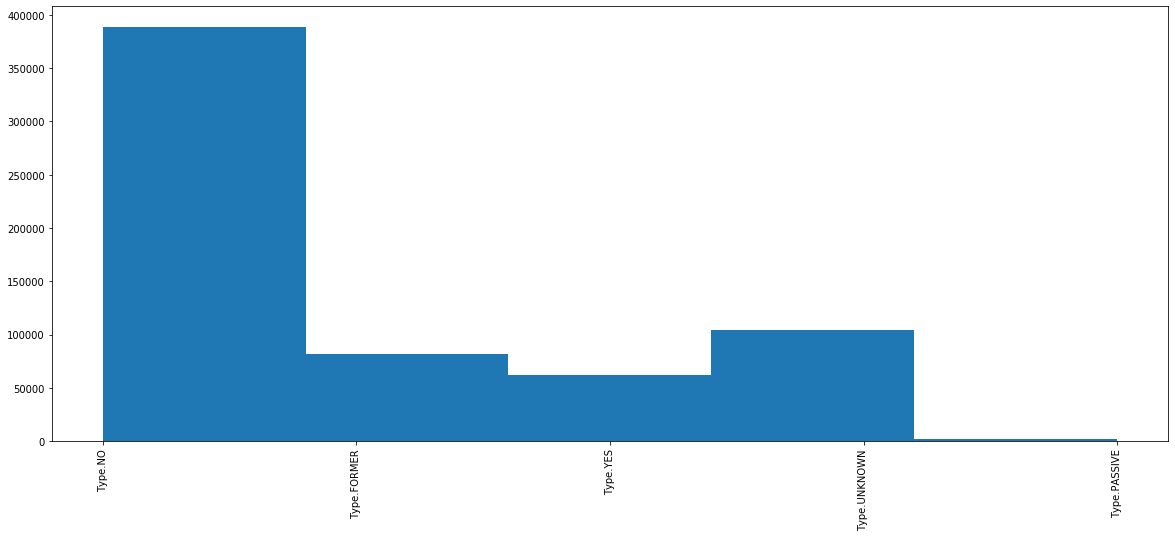

In [36]:
get_diagram(Tobacco_cohort,'hist','value',5)

In [38]:
#AlcoholCondition 
cohort = df_to_cohort(Control_filtered_15_540)
conditions = AlcoholUse()
Alcohol_cohort= cohort.get(conditions)

Fetching data for AlcoholUse (...)


In [39]:
Alcohol_cohort.to_parquet("Control_Alcohol.parquet")

In [30]:
Alcohol_cohort

,medical_record_number,age_in_days,level3_action_name,level4_field_name,value
0,3443154754,24856,Alcohol,Alcohol Use,No
1,1163267172,8770,Alcohol,Alcohol Use,No
2,3178340529,25003,Alcohol,Alcohol Use,Yes
3,3559150790,18948,Alcohol,Alcohol Use,Not Asked
4,735215975,23658,Alcohol,Alcohol Use,Yes
5,2438023993,22758,Alcohol,Alcohol Use,No
6,2721100030,29787,Alcohol,Alcohol Use,No
7,438897183,30241,Alcohol,Alcohol Use,No
8,1127261505,19375,Alcohol,Alcohol Use,No
9,583709392,20369,Alcohol,Alcohol Use,No


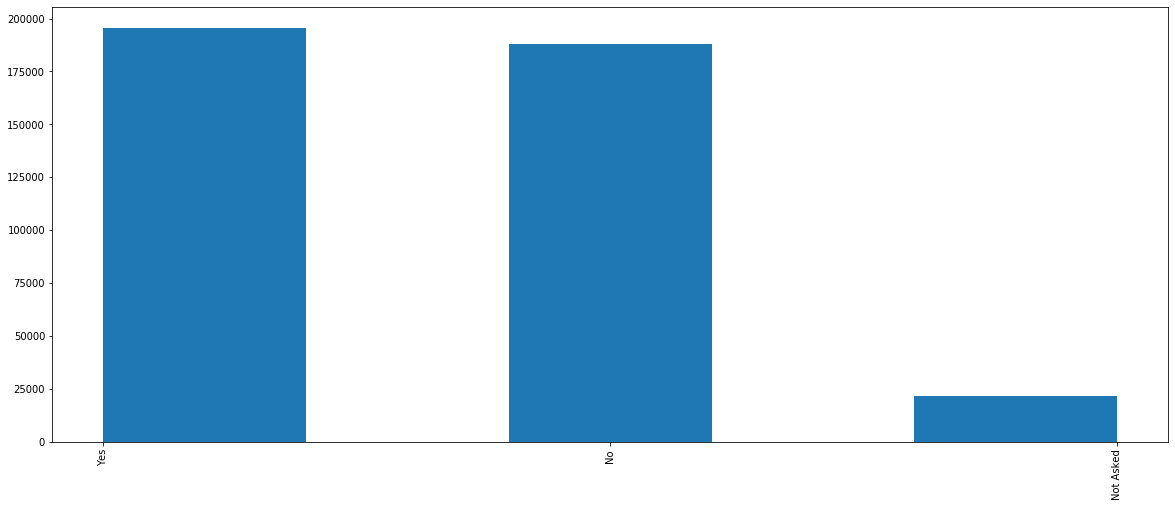

In [40]:
get_diagram(Alcohol_cohort,'hist','value',5)